# Alignment of ISO- Spitzer-JWST spectra
### adding the model spectra of RADMC3D

In [20]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as pltc
%matplotlib inline
#plotting
import chart_studio.plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import seaborn as sb

import pandas as pd
import scipy
import peakutils
import matplotlib.cm as cm

from scipy import signal
from scipy import constants as con
from scipy.signal import find_peaks
from mymisc import *
from glob import glob
from scipy.interpolate import interp1d

import coronagraph as cg

In [21]:
#get spectral data, for specific molcule specie (different folders)
iso = '../obs_data/iso_spectrum.dat'
jwst = '../obs_data/MIRIMRS_all_OD_YLpoly_flux2.dat'
lam_iso, flu_iso, flu_isoerr = np.loadtxt(iso,usecols=(0,1,2),unpack=True,skiprows=7)
lam_jwst, flu_jwst = np.loadtxt(jwst,usecols=(0,1),skiprows=1,unpack=True)

spitzer3 = '../obs_data/SPITZER_S1_12699648_0050.tbl'
spitzer4 = '../obs_data/SPITZER_S1_12699648_0051.tbl'
lam_spi3, flu_spi3, flu_spi3err = np.loadtxt(spitzer3,usecols=(1, 2, 3),unpack=True,skiprows=268)
lam_spi4, flu_spi4, flu_spi4err = np.loadtxt(spitzer4,usecols=(1, 2, 3),unpack=True,skiprows=268)

In [22]:
#resort wavelength and flux
ind0 = lam_iso.argsort()
ind3 = lam_spi3.argsort()
ind4 = lam_spi4.argsort()


lami0,lams3,lams4 = [], [], []
flui0, flus3, flus4 = [], [], []
flui0_err, flus3_err, flus4_err = [], [], []
for i in range(len(ind0)):
    lami0.append(lam_iso[ind0[i]])
    flui0.append(flu_iso[ind0[i]])
    flui0_err.append(flu_isoerr[ind0[i]])
for i in range(len(ind3)):
    if flu_spi3[ind3[i]]>25.:
        lams3.append(lam_spi3[ind3[i]])
        flus3.append(flu_spi3[ind3[i]])
        flus3_err.append(flu_spi3err[ind3[i]])
for i in range(len(ind4)):
    if flu_spi4[ind4[i]]>25.:
        lams4.append(lam_spi4[ind4[i]])
        flus4.append(flu_spi4[ind4[i]])
        flus4_err.append(flu_spi4err[ind4[i]])

### Plotting the spectra

In [23]:
#conversion wave number to wave length and back :)
# for second axis
def wlen(x):
    return x
def wnum(x):
    #x = (1/y*1e4)
    y = (1e4)/x
    return y

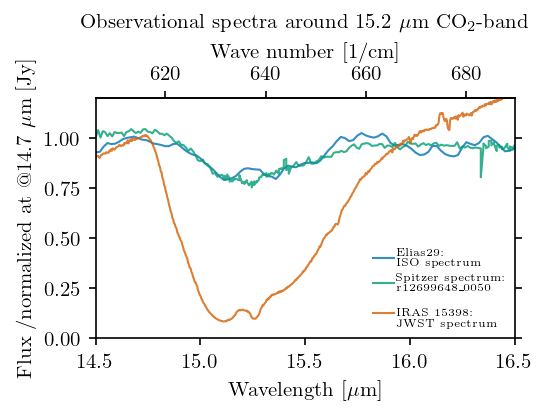

In [24]:
#adjust plotting properties
pagewidth, columnwidth = set_plot_defaults()
fig, ax = plt.subplots(1, 1, figsize=(columnwidth, columnwidth*3/4))

#ranges for CO2 band: Pontoppidan 2205
lam15i = min(range(len(lam_iso)), key=lambda i: abs(lam_iso[i]-14.7)) #normalize to this value
lam15s = min(range(len(lam_spi3)), key=lambda i: abs(lam_spi3[i]-14.7)) #normalize to this value
lam15j = min(range(len(lam_jwst)), key=lambda i: abs(lam_jwst[i]-14.7)) #normalize to this value
norm = flui0[lam15i]

ax.plot(lami0, flui0/norm, linestyle = '-', alpha = 0.8,label = 'Elias29:\nISO spectrum')

ax.plot(lams3, flus3/flus3[lam15s], linestyle = '-', alpha = 0.8,label = 'Spitzer spectrum:\nr12699648_0050')#_8_E7455437')
#ax.plot(lams4, flus4/flus4[lam15s], linestyle = '-', alpha = 0.8,label = 'Spitzer spectrum:\nr12699648_0051')#_8_E7455440')
ax.plot(lam_jwst, flu_jwst/flu_jwst[lam15j], linestyle = '-', alpha = 0.8,label = '\nIRAS 15398:\nJWST spectrum')

ax.set_ylabel(r'Flux /normalized at @14.7 $\mu$m [Jy]')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax2 = ax.secondary_xaxis('top', functions=(wnum, wlen))
ax2.set_xlabel(r'Wave number [1/cm]')
ax.set_xlim(14.5,16.5)
ax.set_ylim(0,1.2)
#plt.yscale('log')
ax.set_title(r'Observational spectra around 15.2 $\mu$m CO$_2$-band')
ax.legend(loc = 'best', prop={'size': 5})
plt.savefig('../plots/7_spectrum_iso_spitzer_jwst.pdf', dpi='figure', format='pdf')

In [29]:
'''
From Will's Tutorial I
https://github.com/willastro/ifw_miri_gto_pstars/blob/main/Tutorial%201%20-%20Continuum%20SED%20(Polynomial)%20-%20Elias%2029.ipynb
'''
#======= nature constants (seem global) =====================
cl      = 2.99792458E+08  # speed of light [m/s]
hplanck = 6.62607554E-34  # Planck's constant [J s]
bk      = 1.38065812E-23  # Boltzmann's constant [J/K]
pi      = np.pi           # just pi
dir = os.getcwd()



def find_nearest(array, value):
    """
    Find nearest value of a given number.

    Parameters
    -------------

    array : 'numpy.ndarray'
        Vector with the value of interest.

    value : 'float'
        Value of interest.

    Returns
    -------------
    Nearest value

    """

    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def get_line_number2(value, matrix):
    """
    Function used to get the line number of a value in a array.

    Parameters
    -------------

    value : 'float'
        Value of interest.

    matrix : 'numpy.ndarray'
        Vector with the value of interest.

    Returns
    ------------

    Index

    """

    for i, line in enumerate(matrix, 1):
        if line == value:
            return i


def Continuum_poly(filename, xmin, xmax, order=2, range_limits=None):
    """
    Calculates the continuum of the Spectral Energy Distribution (SED) using the polynomial fitting.

    Parameters
    -------------

    filename : 'str'
        Three columns file containing the wavelength in units of micrometers, the flux in units of Jansky and the flux error.

    xmin, xmax : 'float'
        Intervals used to calculate the continuum in units of micrometers.

    order : 'float'
        Polynomial order.

    range_limits : 'numpy.ndarray'
        Ranges adopted for the continuum in units of micrometers. E.g. [[2.,3.], [8.,9]]. The funtion will take only these intervals to perform the fit.
        The rest of the spectrum will be masked.
        Default: None

    Returns
    -------------
    ASCII files

    Flux_filename.flux (units of W cm-2)

    Poly_Cont_filename.cont (units of W cm-2)

    Optical_depth_filename.od

    Continuum_filename.pdf

    """

    #======================================================================
    print('Determining the continuum...')
    #=================Input Parameters ====================================

    files = glob(filename)
    count = 0
    fig = plt.figure()
    i = len(files)

    for index in range(i):
        name = files[index]#.rsplit('/', 1)[1]
        t = np.loadtxt(files[index]).T
        x_lam = t[0]
        x_nu = cl/(x_lam*1e-6)
        y = 1e23*t[1]
        ey = 0.1*y #t[2]
        y2 = x_nu*y*1e-30
        ey2 = x_nu*ey*1e-30
        ratio = ey2/y2

        range_limits = range_limits

        if range_limits != None:
            xrange1t = []
            yrange1t = []
            for i in range(len(range_limits)):
                id_n = []
                for j in range(2):
                    frg_lam1 = range_limits[i][j]
                    rg1 = find_nearest(x_lam, frg_lam1) #find number nearby
                    id_n.append(get_line_number2(rg1, x_lam))
                xrange1t.append(x_lam[id_n[0]:id_n[1]])
                yrange1t.append(y2[id_n[0]:id_n[1]])

            xrange1t2 = []
            yrange1t2 = []
            for i in range(len(xrange1t)):
                for j in range(len(xrange1t[i])):
                    xrange1t2.append(xrange1t[i][j])
                    yrange1t2.append(yrange1t[i][j])
        else:
            xrange1t2, yrange1t2 = x_lam, y2


        np.savetxt('Flux_'+name.split('.')[0]+'.flux', np.transpose([x_lam, y2])) #Save the flux in W cm-2 s-1

        lam1, lam2 = xmin, xmax
        pp1 = find_nearest(x_lam, lam1)
        pp2 = find_nearest(x_lam, lam2)
        npoints = 1000
        tt = np.linspace(pp1, pp2, npoints)


        Fcont = np.poly1d(np.polyfit(xrange1t2, yrange1t2, order)) #polynomial fitting
        np.savetxt('Poly_Cont_'+name.split('.')[0]+'.cont', np.transpose([tt, Fcont(tt)]))

        try:
            Fdata = interp1d(x_lam,y2, kind='cubic')	#interpolate data
            etau0 = interp1d(x_lam,ratio, kind='cubic')

        except ValueError:
            Fdata = interp1d(x_lam,y2, kind='linear')	#interpolate data
            etau0 = interp1d(x_lam,ratio, kind='linear')

        tau_poly = -1*np.log(Fdata(tt)/Fcont(tt))
        etau = etau0(tt)
        np.savetxt('Optical_depth_'+name.split('.')[0]+'.od', np.transpose([tt,tau_poly,etau]))

        x_filt_b = x_lam[x_lam <= 2.5]
        y_filt_b = y2[x_lam <= 2.5]
        ey_filt_b = ratio[x_lam <= 2.5]

        x_filt_a = x_lam[x_lam > 2.5]
        y_filt_a = y2[x_lam > 2.5]

        sub1=fig.add_subplot(211)
        sub1.plot(x_filt_a, -1*np.log10(y_filt_a), color='black', label='Observed data')
        sub1.errorbar(x_filt_b, -1*np.log10(y_filt_b), yerr=0.434*ey_filt_b, marker='s', color='grey', linestyle='None')
        sub1.plot(tt, -1*np.log10(Fcont(tt)), ':', color='b', label='Continuum (Polynomial)')
        sub1.minorticks_on()
        sub1.tick_params(which='major', direction='in', labelsize=6)
        sub1.tick_params(which='minor', direction='in', labelsize=6)

        ymin = min(-1*np.log10(y2)) - 0.005*min(-1*np.log10(y2))
        ymax = max(-1*np.log10(y2)) + 0.005*max(-1*np.log10(y2))

        plt.ylim(ymax, ymin)
        #plt.xlim(x_lam[0],x_lam[len(x_lam)-1])
        plt.xlim(tt[0], tt[len(tt)-1])
        plt.legend(loc='best', frameon=False, fontsize=6)
        plt.ylabel(r'$\mathrm{-log(Flux[W cm^{-2}])}$',fontsize=6)
        plt.xlabel(r'$\lambda\ \mathrm{[\mu m]}$',fontsize=6)
        try:
            taumax = max(tau_poly) + 0.1*max(tau_poly)
        except ValueError:
            taumax = 5.
            
        ground = tau_poly*0

        sub2=fig.add_subplot(212)
        
        lam.append(tt)
        dep.append(tau_poly)
        err.append(ey_filt_b)
        con.append(ground)
        sub2.plot(tt, tau_poly, label=None)
        sub2.plot(tt, ground, ':')
        sub2.minorticks_on()
        sub2.tick_params(which='major', direction='in', labelsize=6)
        sub2.tick_params(which='minor', direction='in', labelsize=6)
        #plt.xlim(x_lam[0],x_lam[len(x_lam)-1])
        plt.xlim(tt[0], tt[len(tt)-1])
    

        #try:
        #    plt.ylim(taumax,-0.2)
        #except ValueError:
        #    plt.ylim(5.,-0.2)
        #plt.ylim(0.05,-0.02)
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.legend(loc='best', frameon=False, fontsize=6)
        plt.ylabel(r'Optical Depth$\mathrm{(\tau_{\lambda})}$',fontsize=6)
        plt.xlabel(r'$\lambda\ \mathrm{[\mu m]}$',fontsize=6)

        count = count+1

    plt.show(-0.05,0.05)
    plt.savefig('Continuum_'+filename.split('.')[0]+'.pdf',format='pdf', bbox_inches='tight', dpi=300)

Determining the continuum...


/tmp/ipykernel_4878/99662962.py:115: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_4878/99662962.py:173: RuntimeWarning:

invalid value encountered in log10

/tmp/ipykernel_4878/99662962.py:174: RuntimeWarning:

invalid value encountered in log10

/tmp/ipykernel_4878/99662962.py:180: RuntimeWarning:

invalid value encountered in log10

/tmp/ipykernel_4878/99662962.py:181: RuntimeWarning:

invalid value encountered in log10

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


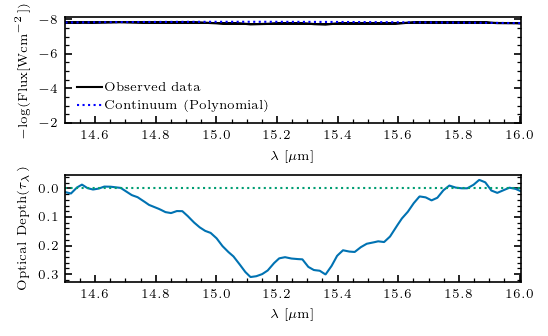

<Figure size 530.854x318.512 with 0 Axes>

In [30]:
#filename = dir+'/'+'Elias29flux.dat'
file_iso = open('./opt_depth_data/iso_data.txt', "a")
for z in range(len(lami0)):
    if flui0_err[z] != 0.:
        file_iso.write(str(lami0[z])+'\t'+str(flui0[z])+'\t'+str(abs(flui0_err[z]))+'\n')
    else:
        file_iso.write(str(lami0[z])+'\t'+str(flui0[z])+'\t'+str(abs(flui0[z])*0.1)+'\n') #to avoid 0 error for chi2-fitiing

#plt.title('Optical depth of iso data')
lam = []
dep = []
err = []
con = []
Continuum_poly("./opt_depth_data/iso_data.txt", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.7,16.0]]) #PART 3
file_iso.close()
iso = lam[0],dep[0]#,np.divide(err[0],flui0), con[0] #contiunuum substract: wavelength, optical depth, opt_d error & continuum

In [32]:
file_jwst = open('iras15389_data.txt', "a")
for l in range(len(lam_jwst)):
    file_jwst.write(str(lam_jwst[l])+'\t'+str(flu_jwst[l])+'\t'+str(abs(flu_jwst[l])*0.1)+'\n') #to avoid 0 error for chi2-fitiing

#plt.title('Optical depth of iso data')
lam = []
dep = []
err = []
con = []
Continuum_poly("iras15398_data.txt", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
file_jwst.close()
jwst = lam[0],dep[0],err[0],con[0] #contiunuum substract: wavelength, optical depth, opt_d error & continuum

Determining the continuum...


<Figure size 530.854x318.512 with 0 Axes>

[]


IndexError: list index out of range

<Figure size 530.854x318.512 with 0 Axes>

In [ ]:
# delete flux 'artefacts' from spitzer spectrum (spikes)
w35 = np.array(flus3) > 25
print( len(lams3))
lams3 = np.array(lams3)[w35]
flus3 = np.array(flus3)[w35]
flus3_err = np.array(flus3_err)[w35]
print(len(flus3_err))
w45 = np.array(flus4) > 25
lams4 = np.array(lams4)[w45]
flus4 = np.array(flus4)[w45]
flus4_err = np.array(flus4_err)[w45]

In [ ]:
sub2=fig.add_subplot(212)
print("./opt_depth_data/spi3_data.txt")
file_spi3 = open("./opt_depth_data/spi3_data.txt", "a")
for z in range(len(lams3)):
    file_spi3.write(str(lams3[z])+'\t'+str(flus3[z])+'\t'+str(flus3_err[z])+'\n')
    
#lam_spi, flu_spi3
lam = []
dep = []
Continuum_poly("./opt_depth_data/spi3_data.txt", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
file_spi3.close()

#complicated work around because Continuum_poly selects range
werr = 14.5 <= lams3
werr = lams3 <= 16
spi3 = lam[0], dep[0],err[0], con[0] #np.divide(flus3_err,flus3) #contiunuum substract: wavelength, optical depth, opt_d error & continuum
print(len(spi3[0]),len(spi3[1]),len(spi3[2]),len(flus3_err))

#for second spitzer data
file_spi4 = open("./opt_depth_data/spi4_data.txt", "a")
for z in range(len(lams4)):
    file_spi4.write(str(lams4[z])+'\t'+str(flus4[z])+'\t'+str(flus4_err[z])+'\n')

lam = []
dep = []
err = []
con = []
Continuum_poly("./opt_depth_data/spi4_data.txt", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
file_spi4.close()

spi4 = lam[0], dep[0], err[0], con[0]# np.divide(flus4_err,flus4) #contiunuum substract: wavelength, optical depth, opt_d error & continuum

In [ ]:
#vizualise the modelled data
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_scat0_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_std = lam[0],dep[0] #contiunuum substract: wavelength, optical depth, opt_d error & continuum
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_abs0_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
abs_std = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_scat_below100K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_100K = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_abs_below100K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
abs_100K = lam[0],dep[0]

In [ ]:
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_abs_30KCO2_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
abs_30KCO2 = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_abs_10KCO2_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
abs_10KCO2 = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_scat_30K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_30KCO2 = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_scat_10K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_10KCO2 = lam[0],dep[0]

In [ ]:
#Observational data
plt.step(iso[0], iso[1]/np.max(iso[1])*np.max(spi3[1]),alpha=0.6, label = 'Elias29:\nISO')
plt.step(spi3[0], spi3[1], '--', alpha=0.4, label = 'Spitzer')#:\nr12699648_0050')
plt.plot(jwst[0], jwst[1]/np.max(jwst[1])*np.max(spi3[1]),alpha=0.6, label = '\nIRAS 15398:\nJWST') #norm optical depth to spitzer

plt.plot(spi3[0], spi3[3], ':', linewidth = 1, label='Continuum\n')
sub2.minorticks_on()
sub2.tick_params(which='major', direction='in', labelsize=6)
sub2.tick_params(which='minor', direction='in', labelsize=6)

#modelled data
plt.plot(scat_std[0], scat_std[1]/np.max(scat_std[1])*np.max(spi3[1]), '-',zorder=9, label='RADMC3D models\nStandard: extinction')
plt.plot(abs_std[0], abs_std[1]/np.max(abs_std[1])*np.max(spi3[1]), '--',zorder=10, label='Standard: absorbtion')
#plt.plot(scat_100K[0], scat_100K[1]/np.max(scat_100K[1])*np.max(spi3[1]), '-.', alpha = 0.6, label='Below 100K: extinction')
# plt.plot(abs_100K[0], abs_100K[1]/np.max(abs_100K[1])*np.max(spi3[1]), '-.', alpha = 0.8, label='Below 100K: absorbtion')

#data to adjust the CO2_peak
plt.xlim(14.4,16.)
plt.ylim(-0.03,0.3)
plt.gca().invert_yaxis()
plt.legend(loc='best', frameon=False, fontsize=5)
plt.title('Comparison of derived optical depths')
plt.ylabel(r'Optical Depth $\mathrm{(\tau_{\lambda})}$',fontsize=6)
plt.xlabel(r'Wavelength $\mathrm{[\mu m]}$',fontsize=6)
plt.savefig('../plots/7_optical_depth_comparison_std.pdf')

In [ ]:
#plt.step(iso[0], iso[1]/np.max(iso[1])*np.max(spi3[1]), label = 'Elias29:\nISO')
plt.step(spi3[0], spi3[1],'--', alpha=0.4, label = 'Elias29: Spitzer')#:\nr12699648_0050')
#plt.plot(jwst[0], jwst[1]/np.max(jwst[1])*np.max(spi3[1]), alpha=0.6,label = 'IRAS 15398: JWST') #norm optical depth to spitzer

#plt.plot(spi3[0], spi3[3], ':', linewidth = 1, label='Continuum\n')
sub2.minorticks_on()
sub2.tick_params(which='major', direction='in', labelsize=6)
sub2.tick_params(which='minor', direction='in', labelsize=6)

#modelled data
#plt.plot(scat_std[0], scat_std[1]/np.max(scat_std[1])*np.max(spi3[1]), '-.', label='RADMC3D models\nFiducial: extinction')
plt.plot(abs_100K[0], abs_100K[1]/np.max(abs_100K[1])*np.max(spi3[1]), '-.', alpha = 0.8, label='RADMC3D models\nBelow 100K: absorbtion')
plt.plot(abs_std[0], abs_std[1]/np.max(abs_std[1])*np.max(spi3[1]), '-', label='Standard: absorbtion')
#plt.plot(scat_100K[0], scat_100K[1]/np.max(scat_100K[1])*np.max(spi3[1]), '-', alpha = 0.6, label='Below 100K: extinction')

#plt.plot(abs_30KCO2[0], abs_30KCO2[1]/np.max(abs_30KCO2[1])*np.max(spi3[1]), '--',alpha=0.6, label=r'T$_{CO_2}<$30K: absorbtion')
#plt.plot(abs_10KCO2[0], abs_10KCO2[1]/np.max(abs_10KCO2[1])*np.max(spi3[1]), '-.', alpha = 0.8, label=r'T$_{CO_2}<$10K: absorbtion')

plt.xlim(14.5,16.2)
plt.ylim(-0.03,0.3)
plt.gca().invert_yaxis()
plt.legend(loc='best', frameon=False, fontsize=5)
plt.title('Comparison of derived optical depth')
plt.ylabel(r'Optical Depth $\mathrm{(\tau_{\lambda})}$',fontsize=6)
plt.xlabel(r'Wavelength $\mathrm{[\mu m]}$',fontsize=6)
plt.savefig('../plots/7_optical_depth_comparison_CO2_temp2_abs.pdf')

In [ ]:
plt.step(iso[0], iso[1]/np.max(iso[1])*np.max(spi3[1]),color='lightgray', label = 'Elias29:\nISO')
plt.step(spi3[0], spi3[1],'-',alpha=0.6, color='dimgray', label = 'Spitzer')#:\nr12699648_0050')
plt.plot(jwst[0], jwst[1]/np.max(jwst[1])*np.max(spi3[1]),color='black', alpha=0.6,label = 'IRAS 15398: JWST') #norm optical depth to spitzer
#plt.plot(spi3[0], spi3[3], ':', linewidth = 1, label='Continuum\n')
sub2.minorticks_on()
sub2.tick_params(which='major', direction='in', labelsize=6)
sub2.tick_params(which='minor', direction='in', labelsize=6)

#modelled data, scattering +
plt.plot(scat_100K[0], scat_100K[1]/np.max(scat_100K[1])*np.max(spi3[1]), '-.', alpha = 0.8, label='RADMC3D models\nBelow 100K: extinction')
plt.plot(scat_std[0], scat_std[1]/np.max(scat_std[1])*np.max(spi3[1]), '-', label='Standard: extinction')
plt.plot(scat_30KCO2[0], scat_30KCO2[1]/np.max(scat_30KCO2[1])*np.max(spi3[1]), '--', alpha=0.6, label=r'T$_{CO_2}<$30K: extinction')
plt.plot(scat_10KCO2[0], scat_10KCO2[1]/np.max(scat_10KCO2[1])*np.max(spi3[1]), '-.', alpha = 0.8, label=r'T$_{CO_2}<$10K: extinction')

plt.xlim(14.5,16.2)
plt.ylim(-0.03,0.3)

plt.gca().invert_yaxis()
plt.legend(loc='best', frameon=False, fontsize=5)
plt.title('Comparison with Ehrenfreund extinction data')
plt.ylabel(r'Optical Depth $\mathrm{(\tau_{\lambda})}$',fontsize=6)
plt.xlabel(r'Wavelength $\mathrm{[\mu m]}$',fontsize=6)
plt.savefig('../plots/7_optical_depth_comparison_CO2_temp_scat.pdf')

In [ ]:
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_scat_broekhuizen_50K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_broek = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_22_08_6_ices_scat_broekhuizen_below100K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_broek_below100K = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_scat_broekhuizen_30K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_broek30K = lam[0],dep[0]
# ------------------------------------------------xxx
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_scat_broekhuizen_10K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_broek10K = lam[0],dep[0]
# ------------------------------------------------xxx
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_abs_Broekhuizen_30K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
abs_broek30K = lam[0],dep[0]
# ------------------------------------------------xxx
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_abs_Broekhuizen_below100K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
abs_broek_below100K = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_abs_Broekhuizen_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
abs_broek = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_abs_Broekhuizen_10K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
abs_broek10K = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_19_08_6_ices_scat_CO2_mix_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_mix = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_22_08_6_ices_scat_broekhuizen_T100K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_broek100K = lam[0],dep[0]

In [ ]:
plt.step(iso[0], iso[1]/np.max(iso[1])*np.max(spi3[1]),color='lightgray', label = 'Elias29: ISO')
plt.step(spi3[0], spi3[1],'-',alpha=0.6, color='dimgray', label = 'Elias29: Spitzer')#:\nr12699648_0050')
plt.plot(jwst[0], jwst[1]/np.max(jwst[1])*np.max(spi3[1]),color='black', alpha=0.8,label = 'IRAS 15398: JWST') #norm optical depth to spitzer

sub2.minorticks_on()
sub2.tick_params(which='major', direction='in', labelsize=6)
sub2.tick_params(which='minor', direction='in', labelsize=6)

#modelled data
plt.plot(scat_std[0], scat_std[1]/np.max(scat_std[1])*np.max(spi3[1]), '-.', label='Ehrenfreund data:\nT$_{CO_2}<$50K')

plt.plot(scat_mix[0], scat_mix[1]/np.max(scat_mix[1])*np.max(spi3[1]), '--', label='PureCO2;\n 1Ehrenfreund:1Broekhuizen')
# check with old Broekhuizen-reference data of optool [#data to adjust the CO2_peak]
#plt.plot(scat_broek_below100K[0], scat_broek_below100K[1]/np.max(scat_broek_below100K[1])*np.max(spi3[1]), '-.',zorder=10, label='All ices below 100K')
#plt.plot(scat_broek100K[0], scat_broek100K[1]/np.max(scat_broek100K[1])*np.max(spi3[1]), '-.',color=col['bluish green'], label='T$_{CO_2}<$100K')
plt.plot(scat_broek[0], scat_broek[1]/np.max(scat_broek[1])*np.max(spi3[1]), '-',color=col['vermillion'], label='Broekhuizen data:\nT$_{CO_2}<$50K (fiducial)')
#plt.plot(scat_broek30K[0], scat_broek30K[1]/np.max(scat_broek30K[1])*np.max(spi3[1]), '--',color=col['sky blue'], label='T$_{CO_2}<$30K')
#plt.plot(scat_broek10K[0], scat_broek10K[1]/np.max(scat_broek10K[1])*np.max(spi3[1]), '-.', color=col['reddish purple'], label='T$_{CO_2}<$10K')

plt.xlim(14.5,16.4)
plt.ylim(-0.03,0.3)
plt.gca().invert_yaxis()
plt.legend(loc='best', frameon=False, fontsize=5)
plt.title('Combining ice species Ehrenfreund:Broekhuizen [extinction]')
plt.ylabel(r'Optical Depth $\mathrm{(\tau_{\lambda})}$',fontsize=6)
plt.xlabel(r'Wavelength $\mathrm{[\mu m]}$',fontsize=6)
plt.savefig('../plots/7_optical_depth_comparison_CO2_broekhuizen_mix.pdf')

In [ ]:
#plt.step(iso[0], iso[1]/np.max(iso[1])*np.max(spi3[1]), label = 'Elias29:\nISO')
#plt.step(spi3[0], spi3[1],'--', alpha=0.4, label = 'Elias29: Spitzer')#:\nr12699648_0050')
#plt.plot(jwst[0], jwst[1]/np.max(jwst[1])*np.max(spi3[1]), alpha=0.6,label = 'IRAS 15398: JWST') #norm optical depth to spitzer

#plt.plot(spi3[0], spi3[3], ':', linewidth = 1, label='Continuum\n')
sub2.minorticks_on()
sub2.tick_params(which='major', direction='in', labelsize=6)
sub2.tick_params(which='minor', direction='in', labelsize=6)

#modelled data

# check with old Broekhuizen-reference data of optool [#data to adjust the CO2_peak]
plt.plot(abs_broek_below100K[0], abs_broek_below100K[1]/np.max(abs_broek_below100K[1])*np.max(spi3[1]), '-.', zorder=2, alpha = 0.6, label='Absorption:\nAll ices below 100K')
plt.plot(abs_broek[0], abs_broek[1]/np.max(abs_broek[1])*np.max(spi3[1]), '-',zorder=1, label='T$_{CO_2}<$50K')
#plt.plot(abs_broek30K[0], abs_broek30K[1]/np.max(abs_broek30K[1])*np.max(spi3[1]), '--', alpha = 0.6, label='T$_{CO_2}<$30K')
#plt.plot(abs_broek10K[0], abs_broek10K[1]/np.max(abs_broek10K[1])*np.max(spi3[1]), '-.', alpha = 0.8, label='T$_{CO_2}<$10K')

plt.plot(scat_broek_below100K[0], scat_broek_below100K[1]/np.max(scat_broek_below100K[1])*np.max(spi3[1]), '-.', zorder=3, alpha = 0.6, label='Extinction:\nAll ices below 100K')
plt.plot(scat_broek[0], scat_broek[1]/np.max(scat_broek[1])*np.max(spi3[1]), ':',color=col['vermillion'], label='T$_{CO_2}<$50K (fiducial)')
#plt.plot(scat_broek30K[0], scat_broek30K[1]/np.max(scat_broek30K[1])*np.max(spi3[1]), '--', alpha = 0.6, label='T$_{CO_2}<$30K')
#plt.plot(scat_broek10K[0], scat_broek10K[1]/np.max(scat_broek10K[1])*np.max(spi3[1]), '-.', alpha = 0.8, label='T$_{CO_2}<$10K')

plt.xlim(14.5,16.)
plt.ylim(-0.03,0.3)
plt.gca().invert_yaxis()
plt.legend(loc='best', frameon=False, fontsize=5)
plt.title('Comparison of Broekhuizen: absorption vs extinction')
plt.ylabel(r'Optical Depth $\mathrm{(\tau_{\lambda})}$',fontsize=6)
plt.xlabel(r'Wavelength $\mathrm{[\mu m]}$',fontsize=6)
plt.savefig('../plots/7_optical_depth_comparison_CO2_broekhuizen_compare.pdf')

In [ ]:
#plt.step(iso[0], iso[1]/np.max(iso[1])*np.max(spi3[1]), label = 'Elias29:\nISO')
plt.step(spi3[0], spi3[1],'-',alpha=0.6, color='dimgray', label = 'Elias29: Spitzer')#:\nr12699648_0050')
#plt.plot(jwst[0], jwst[1]/np.max(jwst[1])*np.max(spi3[1]), alpha=0.6,label = 'IRAS 15398: JWST') #norm optical depth to spitzer

#plt.plot(spi3[0], spi3[3], ':', linewidth = 1, label='Continuum\n')
sub2.minorticks_on()
sub2.tick_params(which='major', direction='in', labelsize=6)
sub2.tick_params(which='minor', direction='in', labelsize=6)

#modelled data
plt.plot(scat_10KCO2[0], scat_10KCO2[1]/np.max(scat_10KCO2[1])*np.max(spi3[1]), '-', alpha = 0.8, label='Ehrenfreund data:\nT$_{CO_2}<$10K: extinction')
plt.plot(abs_10KCO2[0], abs_10KCO2[1]/np.max(abs_10KCO2[1])*np.max(spi3[1]), '--', label=r'T$_{CO_2}<$10K: absorption')
plt.plot(scat_broek30K[0], scat_broek30K[1]/np.max(scat_broek30K[1])*np.max(spi3[1]), '-.', alpha = 0.8, label='Broekhuizen data:\nT$_{CO_2}<$30K: extinction')
plt.plot(scat_broek10K[0], scat_broek10K[1]/np.max(scat_broek10K[1])*np.max(spi3[1]), '--', alpha = 0.6, label='T$_{CO_2}<$10K: extinction')
plt.plot(abs_broek10K[0], abs_broek10K[1]/np.max(abs_broek10K[1])*np.max(spi3[1]), ':', label='T$_{CO_2}<$10K: absorption')

plt.xlim(14.5,16.3)
plt.ylim(-0.03,0.3)
plt.gca().invert_yaxis()
plt.legend(loc='best', frameon=False, fontsize=5)
plt.title('Comparison of derived optical depth of Elias 29')
plt.ylabel(r'Optical Depth $\mathrm{(\tau_{\lambda})}$',fontsize=6)
plt.xlabel(r'Wavelength $\mathrm{[\mu m]}$',fontsize=6)
plt.savefig('../plots/7_optical_depth_comparison_CO2_elias29.pdf')

In [ ]:
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_18_08_6_ices_scat_PalumboCO2_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_palo = lam[0],dep[0]
# ---------------------------------------------------
lam = []
dep = []
Continuum_poly("./model_data/spectrum_18_08_6_ices_scat_PalumboCO2_30K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_palo30K = lam[0],dep[0]
# ------------------------------------------------xxx
lam = []
dep = []
Continuum_poly("./model_data/spectrum_18_08_6_ices_scat_PalumboCO2_10K_zoom.out", 14.5, 16, order = 3, range_limits=[[14.5,14.7],[15.9,16.]]) #PART 3
scat_palo10K = lam[0],dep[0]

In [ ]:
plt.step(iso[0], iso[1]/np.max(iso[1])*np.max(spi3[1]),color='lightgray', label = 'Elias29: ISO')
#plt.step(spi3[0], spi3[1],'-',alpha=0.6, color='dimgray', label = 'Spitzer')#:\nr12699648_0050')
#plt.plot(jwst[0], jwst[1]/np.max(jwst[1])*np.max(spi3[1]),color='black', alpha=0.6,label = 'IRAS 15398: JWST') #norm optical depth to spitzer
#plt.plot(spi3[0], spi3[3], ':', linewidth = 1, label='Continuum\n')
sub2.minorticks_on()
sub2.tick_params(which='major', direction='in', labelsize=6)
sub2.tick_params(which='minor', direction='in', labelsize=6)

#modelled data
plt.plot(scat_broek10K[0], scat_broek10K[1]/np.max(scat_broek10K[1])*np.max(spi3[1]), '-.', label='RADMC3D [extinction]\nBroekhuizen data:\n below 100K')
plt.plot(scat_broek[0], scat_broek[1]/np.max(scat_broek[1])*np.max(spi3[1]), '-',color=col['vermillion'], label='T$_{CO_2}<$50K: fiducial')
plt.plot(scat_broek30K[0], scat_broek30K[1]/np.max(scat_broek30K[1])*np.max(spi3[1]), '--', label='T$_{CO_2}<$30K')
plt.plot(scat_broek10K[0], scat_broek10K[1]/np.max(scat_broek10K[1])*np.max(spi3[1]), ls=(0, (3, 1, 1, 1)), alpha = 0.8, label='T$_{CO_2}<$10K')
plt.plot(scat_palo[0], scat_palo[1]/np.max(scat_palo[1])*np.max(spi3[1]), '-', label='Palumbo data:\nT$_{CO_2}<$50K')
plt.plot(scat_palo30K[0], scat_palo30K[1]/np.max(scat_palo30K[1])*np.max(spi3[1]), '--', label='T$_{CO_2}<$30K')
plt.plot(scat_palo10K[0], scat_palo10K[1]/np.max(scat_palo10K[1])*np.max(spi3[1]), '-.', alpha = 0.8, label='T$_{CO_2}<$10K')


plt.xlim(14.5,16.5)
plt.ylim(-0.03,0.3)
plt.gca().invert_yaxis()
plt.legend(loc='best', frameon=False, fontsize=5)
plt.title('Comparison of different CO$_2$ models: Elias 29 ISO')
plt.ylabel(r'Optical Depth $\mathrm{(\tau_{\lambda})}$',fontsize=6)
plt.xlabel(r'Wavelength $\mathrm{[\mu m]}$',fontsize=6)
plt.savefig('../plots/7_optical_depth_comparison_iso.pdf')

In [ ]:
plt.step(iso[0], iso[1]/np.max(iso[1])*np.max(spi3[1]),color='lightgray', label = 'Elias29: ISO')
plt.step(spi3[0], spi3[1],'-',alpha=0.6, color='dimgray', label = 'Elias29: Spitzer')#:\nr12699648_0050')
plt.plot(jwst[0], jwst[1]/np.max(jwst[1])*np.max(spi3[1]),color='black', alpha=0.6,label = 'IRAS 15398: JWST') #norm optical depth to spitzer

#plt.plot(spi3[0], spi3[3], ':', linewidth = 1, label='Continuum\n')
sub2.minorticks_on()
sub2.tick_params(which='major', direction='in', labelsize=6)
sub2.tick_params(which='minor', direction='in', labelsize=6)

#modelled data
plt.plot(scat_std[0], scat_std[1]/np.max(scat_std[1])*np.max(spi3[1]), '-.', alpha = 0.8, label='Ehrenfreund data:\nT$_{CO_2}<$50K')
plt.plot(scat_palo[0], scat_palo[1]/np.max(scat_palo[1])*np.max(spi3[1]), '--', label='Palumbo data:\nT$_{CO_2}<$50K')
plt.plot(scat_broek[0], scat_broek[1]/np.max(scat_broek[1])*np.max(spi3[1]), '-', alpha = 0.8, label='Broekhuizen data:\nT$_{CO_2}<$50K (fiducial)')

plt.xlim(14.5,16.3)
plt.ylim(-0.03,0.3)
plt.gca().invert_yaxis()
plt.legend(loc='best', frameon=False, fontsize=5)
plt.title('Optical depth: CO$_2$ datasets: extinction')
plt.ylabel(r'Optical Depth $\mathrm{(\tau_{\lambda})}$',fontsize=6)
plt.xlabel(r'Wavelength $\mathrm{[\mu m]}$',fontsize=6)
plt.savefig('../plots/7_optical_depth_comparison_CO2_below100K.pdf')